In [2]:
import numpy as np
import matplotlib.pylab as plt
import scipy
from numba import jit
import pandas as pd

In [3]:
THIS = 'dissipation-theory--Study-55--'
figs = {}

We wish to compute a numerical approximation to the following unitless integral:

\begin{equation}
{\cal I}_{\ell}(x) = \int_{0}^{\infty} dy \, y^{\ell} e^{-y} J_{0}(y \, x).
\end{equation}

The integral has the following analytical solutions:
\begin{equation}
{\cal I}_{0}^{\mathrm{calc}}(x) = \frac{1}{(1 + x^2)^{1/2}}, \text{ }
{\cal I}_{1}^{\mathrm{calc}}(x) = \frac{1}{(1 + x^2)^{3/2}}, \text{ and }
{\cal I}_{2}^{\mathrm{calc}}(x) = \frac{2 - x^2}{(1 + x^2)^{5/2}}
\end{equation}
I indicate that these are exact calculated integrals with a superscript "calc", to distinguish these results from the integrals ${\cal I}_{\ell}(x)$ that we are going to compute numerically.

A compiled function representing the integrand.  Here `ell` stands for $\ell$.

In [4]:
@jit(nopython=True)
def integrand(ell, y, x):
    return y**ell * np.exp(-y) * scipy.special.j0(y * x)

A mockup of my Newton-Cotes integration integration formula ([Wikipedia](https://en.wikipedia.org/wiki/Newton%E2%80%93Cotes_formulas), [MathWorld](https://mathworld.wolfram.com/Newton-CotesFormulas.html), [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.newton_cotes.html)).  

In code below, `an` are the weights, which you would precompute by calling

    an, _ = scipy.integrate.newton_cotes(N, 1)

for an $N$th order integration.  We could include the above line in the function, but then we would not be able to compile it.  The Newton-Cotes algorithm assumes that the data is equally spaced.  So we have to choose an upper cutoff for $y$, below called `ymax`.

In [3]:
@jit(nopython=True)
def Imockup(ell, x, an, ymax):
    
    N = len(an) - 1
    y_vector = np.linspace(0., ymax, N+1)
    dy = ymax / N
    
    integral = np.zeros_like(y_vector)
    for m, y in enumerate(y_vector):
        integral[m] = integrand(ell, y, x)
    
    return dy * (an * integral).sum()

A compiled function to impliment the exact integrals ${\cal I}_{0}(x)$, ${\cal I}_{1}(x)$, and ${\cal I}_{0}(x)$, which we can compare to the result of our Newton-Cotes integration.

In [4]:
@jit(nopython=True)
def Iexact(ell, x):
    if ell == 0:
        return np.power(1 + x**2, -1/2)
    elif ell == 1:
        return np.power(1 + x**2, -3/2)
    elif ell == 2:
        return (2 - x**2) * np.power(1 + x**2, -5/2)

This function generates a table computing ${\cal I}_{n}(x)$ for $x$ ranging from 0 to 3.  The table shows the numerically calculated integral, the exact answer, and the relative error in `ppt` or *part per thousand*.

In [5]:
def xaccuracy(N, ymax):

    an, _ = scipy.integrate.newton_cotes(N, 1)
    
    x_vector = np.linspace(0.,3.,16)
    
    I = np.zeros((3,len(x_vector)))
    Icalc = np.zeros((3,len(x_vector)))
    
    for index in [0, 1, 2]:
        
        I[index,:] = np.array([[Imockup(index, x, an, ymax) for x in x_vector]])
        Icalc[index,:] =  np.array([[Iexact(index, x) for x in x_vector]])
        
    epsilon = 1e3 * (I - Icalc)/Icalc

    inputs = {'x': x_vector, 
          'I0': I[0,:], 'I0 calc': Icalc[0,:], 'err0 [ppt]': epsilon[0,:],
          'I1': I[1,:], 'I1 calc': Icalc[1,:], 'err1 [ppt]': epsilon[1,:],
          'I2': I[2,:], 'I2 calc': Icalc[2,:], 'err2 [ppt]': epsilon[2,:]}

    df = pd.DataFrame.from_dict(inputs)
    
    pd.options.display.float_format = '{:.3f}'.format
    
    def bold_column_elements(s):
        return ['font-weight: bold' 
            if ((s.name == 'err0 [ppt]') or (s.name == 'err1 [ppt]') or (s.name == 'err2 [ppt]')) 
            else '' for _ in s]
    
    df = df.style.apply(bold_column_elements, axis=0)

    return df

Generate tables for different values of $N$, the order of the Newton-Cotes integration, and $y_{\mathrm{max}}$, the upper range of integration.

# $N = 25$ tables

In [6]:
for ymax in [7.5, 10.0, 12.5, 15.0, 17.5, 20.]:
    print("="*20)
    print("ymax = {:0.2f}".format(ymax))
    display(xaccuracy(25, ymax))

ymax = 7.50


,x,I0,I0 calc,err0 [ppt],I1,I1 calc,err1 [ppt],I2,I2 calc,err2 [ppt]
0,0.000000,0.999447,1.000000,-0.553088,0.995299,1.000000,-4.701236,1.959486,2.000000,-20.256761
1,0.200000,0.980361,0.980581,-0.224427,0.941058,0.942866,-1.917570,1.762004,1.776940,-8.405088
2,0.400000,0.928661,0.928477,0.198370,0.801985,0.800411,1.966114,1.283210,1.269617,10.706473
3,0.600000,0.857575,0.857493,0.096034,0.631125,0.630510,0.976015,0.764801,0.760320,5.892883
4,0.800000,0.780747,0.780869,-0.156427,0.475124,0.476140,-2.132503,0.386389,0.394847,-21.422398
5,1.000000,0.707064,0.707107,-0.060333,0.353260,0.353553,-0.829333,0.174871,0.176777,-10.777661
6,1.200000,0.640269,0.640184,0.132928,0.263060,0.262371,2.625686,0.065780,0.060216,92.396357
7,1.400000,0.581266,0.581238,0.048051,0.196551,0.196364,0.949083,0.003828,0.002654,442.734603
8,1.600000,0.529937,0.529999,-0.116055,0.148387,0.148876,-3.287554,-0.027299,-0.023419,165.711254
9,1.800000,0.485621,0.485643,-0.045301,0.114390,0.114538,-1.296751,-0.034462,-0.033497,28.795295


ymax = 10.00


,x,I0,I0 calc,err0 [ppt],I1,I1 calc,err1 [ppt],I2,I2 calc,err2 [ppt]
0,0.000000,0.999955,1.000000,-0.045401,0.999501,1.000000,-0.499405,1.994461,2.000000,-2.769418
1,0.200000,0.980575,0.980581,-0.005283,0.942814,0.942866,-0.055541,1.776418,1.776940,-0.293880
2,0.400000,0.928491,0.928477,0.015897,0.800569,0.800411,0.197177,1.271308,1.269617,1.331876
3,0.600000,0.857483,0.857493,-0.012030,0.630396,0.630510,-0.179675,0.759071,0.760320,-1.642826
4,0.800000,0.780869,0.780869,-0.000006,0.476144,0.476140,0.009335,0.394948,0.394847,0.253571
5,1.000000,0.707114,0.707107,0.009566,0.353622,0.353553,0.195371,0.177478,0.176777,3.967440
6,1.200000,0.640179,0.640184,-0.008946,0.262310,0.262371,-0.232948,0.059565,0.060216,-10.820950
7,1.400000,0.581238,0.581238,-0.000024,0.196367,0.196364,0.012176,0.002706,0.002654,19.835823
8,1.600000,0.530003,0.529999,0.007871,0.148918,0.148876,0.281580,-0.022999,-0.023419,-17.902332
9,1.800000,0.485640,0.485643,-0.006949,0.114503,0.114538,-0.311113,-0.033872,-0.033497,11.177863


ymax = 12.50


,x,I0,I0 calc,err0 [ppt],I1,I1 calc,err1 [ppt],I2,I2 calc,err2 [ppt]
0,0.000000,0.999996,1.000000,-0.003727,0.999950,1.000000,-0.050311,1.999317,2.000000,-0.341461
1,0.200000,0.980581,0.980581,0.000516,0.942873,0.942866,0.007538,1.777040,1.776940,0.056613
2,0.400000,0.928477,0.928477,0.000195,0.800413,0.800411,0.002533,1.269639,1.269617,0.016808
3,0.600000,0.857492,0.857493,-0.000621,0.630503,0.630510,-0.010681,0.760236,0.760320,-0.111298
4,0.800000,0.780869,0.780869,0.000831,0.476148,0.476140,0.017571,0.394955,0.394847,0.272472
5,1.000000,0.707106,0.707107,-0.000822,0.353546,0.353553,-0.021413,0.176678,0.176777,-0.557696
6,1.200000,0.640185,0.640184,0.000602,0.262376,0.262371,0.019566,0.060284,0.060216,1.131028
7,1.400000,0.581238,0.581238,-0.000257,0.196362,0.196364,-0.009742,0.002625,0.002654,-10.620464
8,1.600000,0.529999,0.529999,-0.000158,0.148876,0.148876,0.001140,-0.023429,-0.023419,0.438049
9,1.800000,0.485643,0.485643,0.000657,0.114548,0.114538,0.083147,-0.033481,-0.033497,-0.481615


ymax = 15.00


,x,I0,I0 calc,err0 [ppt],I1,I1 calc,err1 [ppt],I2,I2 calc,err2 [ppt]
0,0.000000,1.000000,1.000000,-0.000306,0.999995,1.000000,-0.004894,1.999921,2.000000,-0.039308
1,0.200000,0.980581,0.980581,0.000097,0.942868,0.942866,0.001632,1.776965,1.776940,0.014013
2,0.400000,0.928477,0.928477,-0.000073,0.800410,0.800411,-0.001364,1.269600,1.269617,-0.013916
3,0.600000,0.857493,0.857493,0.000060,0.630510,0.630510,0.001330,0.760334,0.760320,0.017785
4,0.800000,0.780869,0.780869,-0.000053,0.476139,0.476140,-0.001388,0.394837,0.394847,-0.026904
5,1.000000,0.707107,0.707107,0.000049,0.353554,0.353553,0.001335,0.176785,0.176777,0.047960
6,1.200000,0.640184,0.640184,-0.000065,0.262370,0.262371,-0.002753,0.060215,0.060216,-0.024366
7,1.400000,0.581238,0.581238,-0.000507,0.196364,0.196364,-0.002631,0.002703,0.002654,18.726776
8,1.600000,0.529996,0.529999,-0.005507,0.148876,0.148876,0.000340,-0.023109,-0.023419,-13.228757
9,1.800000,0.485622,0.485643,-0.043132,0.114533,0.114538,-0.045873,-0.031593,-0.033497,-56.845285


ymax = 17.50


,x,I0,I0 calc,err0 [ppt],I1,I1 calc,err1 [ppt],I2,I2 calc,err2 [ppt]
0,0.000000,1.000000,1.000000,-0.000025,1.000000,1.000000,-0.000466,1.999991,2.000000,-0.004298
1,0.200000,0.980581,0.980581,0.000010,0.942866,0.942866,0.000193,1.776943,1.776940,0.001892
2,0.400000,0.928477,0.928477,-0.000007,0.800411,0.800411,-0.000153,1.269615,1.269617,-0.001714
3,0.600000,0.857493,0.857493,0.000003,0.630510,0.630510,0.000107,0.760321,0.760320,0.001551
4,0.800000,0.780869,0.780869,-0.000000,0.476140,0.476140,0.000104,0.394846,0.394847,-0.003974
5,1.000000,0.707107,0.707107,0.000090,0.353553,0.353553,-0.001118,0.176769,0.176777,-0.041746
6,1.200000,0.640185,0.640184,0.000596,0.262363,0.262371,-0.027818,0.060207,0.060216,-0.154570
7,1.400000,0.581239,0.581238,0.001339,0.196301,0.196364,-0.323221,0.002715,0.002654,23.191247
8,1.600000,0.529998,0.529999,-0.002351,0.148431,0.148876,-2.991642,-0.023478,-0.023419,2.552451
9,1.800000,0.485663,0.485643,0.040374,0.111924,0.114538,-22.828654,-0.041975,-0.033497,253.108587


ymax = 20.00


,x,I0,I0 calc,err0 [ppt],I1,I1 calc,err1 [ppt],I2,I2 calc,err2 [ppt]
0,0.000000,1.000000,1.000000,-0.000001,1.000000,1.000000,-0.000057,1.999999,2.000000,-0.000345
1,0.200000,0.980581,0.980581,0.000000,0.942866,0.942866,0.000024,1.776940,1.776940,0.000138
2,0.400000,0.928477,0.928477,0.000001,0.800411,0.800411,-0.000025,1.269617,1.269617,-0.000004
3,0.600000,0.857493,0.857493,-0.000007,0.630509,0.630510,-0.000032,0.760322,0.760320,0.001844
4,0.800000,0.780869,0.780869,-0.000050,0.476141,0.476140,0.002187,0.394840,0.394847,-0.018078
5,1.000000,0.707107,0.707107,0.000641,0.353557,0.353553,0.011455,0.176669,0.176777,-0.607681
6,1.200000,0.640191,0.640184,0.010080,0.262362,0.262371,-0.033221,0.059422,0.060216,-13.197534
7,1.400000,0.581290,0.581238,0.089667,0.196201,0.196364,-0.829680,-0.002748,0.002654,-2035.449132
8,1.600000,0.530362,0.529999,0.685241,0.148333,0.148876,-3.650262,-0.056411,-0.023419,1408.815825
9,1.800000,0.487803,0.485643,4.447277,0.118997,0.114538,38.927191,-0.173283,-0.033497,4173.077992


# $N = 30$ tables

In [7]:
for ymax in [7.5, 10.0, 12.5, 15.0, 17.5, 20.]:
    print("="*20)
    print("ymax = {:0.2f}".format(ymax))
    display(xaccuracy(30, ymax))

ymax = 7.50


,x,I0,I0 calc,err0 [ppt],I1,I1 calc,err1 [ppt],I2,I2 calc,err2 [ppt]
0,0.000000,0.999440,1.000000,-0.559941,0.995271,1.000000,-4.728731,1.959375,2.000000,-20.312615
1,0.200000,0.980355,0.980581,-0.230324,0.941035,0.942866,-1.942111,1.761910,1.776940,-8.457992
2,0.400000,0.928658,0.928477,0.195063,0.801973,0.800411,1.950960,1.283161,1.269617,10.667584
3,0.600000,0.857575,0.857493,0.096072,0.631125,0.630510,0.976773,0.764802,0.760320,5.894888
4,0.800000,0.780749,0.780869,-0.153628,0.475133,0.476140,-2.112997,0.386426,0.394847,-21.328631
5,1.000000,0.707067,0.707107,-0.056657,0.353271,0.353553,-0.797640,0.174917,0.176777,-10.521895
6,1.200000,0.640271,0.640184,0.135069,0.263066,0.262371,2.650965,0.065808,0.060216,92.865301
7,1.400000,0.581265,0.581238,0.046913,0.196549,0.196364,0.942994,0.003827,0.002654,442.305486
8,1.600000,0.529935,0.529999,-0.120540,0.148379,0.148876,-3.341852,-0.027327,-0.023419,166.876818
9,1.800000,0.485618,0.485643,-0.051275,0.114379,0.114538,-1.391109,-0.034501,-0.033497,29.955234


ymax = 10.00


,x,I0,I0 calc,err0 [ppt],I1,I1 calc,err1 [ppt],I2,I2 calc,err2 [ppt]
0,0.000000,0.999952,1.000000,-0.047844,0.999488,1.000000,-0.512036,1.994393,2.000000,-2.803533
1,0.200000,0.980574,0.980581,-0.007128,0.942804,0.942866,-0.065283,1.776368,1.776940,-0.321780
2,0.400000,0.928491,0.928477,0.015445,0.800567,0.800411,0.195169,1.271300,1.269617,1.325183
3,0.600000,0.857483,0.857493,-0.011283,0.630400,0.630510,-0.172910,0.759095,0.760320,-1.611610
4,0.800000,0.780869,0.780869,0.000821,0.476148,0.476140,0.018785,0.394974,0.394847,0.320124
5,1.000000,0.707113,0.707107,0.009280,0.353622,0.353553,0.195440,0.177482,0.176777,3.989110
6,1.200000,0.640178,0.640184,-0.010528,0.262305,0.262371,-0.250733,0.059544,0.060216,-11.170148
7,1.400000,0.581237,0.581238,-0.001695,0.196361,0.196364,-0.015221,0.002679,0.002654,9.490599
8,1.600000,0.530003,0.529999,0.007899,0.148917,0.148876,0.272651,-0.023010,-0.023419,-17.447008
9,1.800000,0.485641,0.485643,-0.004395,0.114507,0.114538,-0.271557,-0.033855,-0.033497,10.671175


ymax = 12.50


,x,I0,I0 calc,err0 [ppt],I1,I1 calc,err1 [ppt],I2,I2 calc,err2 [ppt]
0,0.000000,0.999995,1.000000,-0.004610,0.999945,1.000000,-0.055482,1.999283,2.000000,-0.358529
1,0.200000,0.980581,0.980581,-0.000075,0.942870,0.942866,0.004252,1.777020,1.776940,0.045372
2,0.400000,0.928477,0.928477,0.000153,0.800414,0.800411,0.003306,1.269644,1.269617,0.021285
3,0.600000,0.857493,0.857493,-0.000483,0.630504,0.630510,-0.007962,0.760250,0.760320,-0.092764
4,0.800000,0.780869,0.780869,0.000596,0.476147,0.476140,0.016535,0.394955,0.394847,0.272249
5,1.000000,0.707106,0.707107,-0.001386,0.353543,0.353553,-0.028619,0.176663,0.176777,-0.644180
6,1.200000,0.640185,0.640184,0.000482,0.262374,0.262371,0.014495,0.060273,0.060216,0.946882
7,1.400000,0.581239,0.581238,0.000685,0.196364,0.196364,0.000841,0.002634,0.002654,-7.310880
8,1.600000,0.530000,0.529999,0.001294,0.148879,0.148876,0.021151,-0.023406,-0.023419,-0.560370
9,1.800000,0.485643,0.485643,0.000912,0.114543,0.114538,0.036501,-0.033454,-0.033497,-1.281463


ymax = 15.00


,x,I0,I0 calc,err0 [ppt],I1,I1 calc,err1 [ppt],I2,I2 calc,err2 [ppt]
0,0.000000,0.999999,1.000000,-0.000671,0.999993,1.000000,-0.006975,1.999906,2.000000,-0.046876
1,0.200000,0.980581,0.980581,-0.000145,0.942867,0.942866,0.000519,1.776958,1.776940,0.010316
2,0.400000,0.928477,0.928477,-0.000140,0.800410,0.800411,-0.000971,1.269605,1.269617,-0.009981
3,0.600000,0.857493,0.857493,-0.000038,0.630510,0.630510,0.001181,0.760336,0.760320,0.020229
4,0.800000,0.780869,0.780869,-0.000228,0.476138,0.476140,-0.003614,0.394829,0.394847,-0.045774
5,1.000000,0.707107,0.707107,0.000120,0.353554,0.353553,0.000795,0.176781,0.176777,0.022773
6,1.200000,0.640185,0.640184,0.000464,0.262372,0.262371,0.004700,0.060219,0.060216,0.038363
7,1.400000,0.581238,0.581238,0.000479,0.196366,0.196364,0.009810,0.002669,0.002654,5.989000
8,1.600000,0.529999,0.529999,-0.000300,0.148875,0.148876,-0.007048,-0.023426,-0.023419,0.300046
9,1.800000,0.485643,0.485643,-0.000831,0.114536,0.114538,-0.018960,-0.033497,-0.033497,0.000528


ymax = 17.50


,x,I0,I0 calc,err0 [ppt],I1,I1 calc,err1 [ppt],I2,I2 calc,err2 [ppt]
0,0.000000,1.000000,1.000000,-0.000211,0.999999,1.000000,-0.001399,1.999985,2.000000,-0.007539
1,0.200000,0.980581,0.980581,-0.000126,0.942866,0.942866,-0.000323,1.776941,1.776940,0.000698
2,0.400000,0.928477,0.928477,-0.000086,0.800411,0.800411,-0.000275,1.269617,1.269617,-0.000567
3,0.600000,0.857493,0.857493,-0.000067,0.630509,0.630510,-0.000527,0.760319,0.760320,-0.001760
4,0.800000,0.780869,0.780869,0.000029,0.476139,0.476140,-0.000340,0.394844,0.394847,-0.007576
5,1.000000,0.707107,0.707107,0.000220,0.353554,0.353553,0.002326,0.176781,0.176777,0.025109
6,1.200000,0.640185,0.640184,0.000178,0.262371,0.262371,0.002939,0.060222,0.060216,0.096843
7,1.400000,0.581238,0.581238,-0.000134,0.196363,0.196364,-0.003986,0.002647,0.002654,-2.552419
8,1.600000,0.529999,0.529999,0.000008,0.148873,0.148876,-0.022196,-0.023442,-0.023419,0.980870
9,1.800000,0.485644,0.485643,0.002729,0.114511,0.114538,-0.236586,-0.033696,-0.033497,5.939063


ymax = 20.00


,x,I0,I0 calc,err0 [ppt],I1,I1 calc,err1 [ppt],I2,I2 calc,err2 [ppt]
0,0.000000,1.000000,1.000000,-0.000114,0.999999,1.000000,-0.000562,1.999996,2.000000,-0.001970
1,0.200000,0.980581,0.980581,-0.000088,0.942866,0.942866,-0.000337,1.776939,1.776940,-0.000451
2,0.400000,0.928477,0.928477,-0.000055,0.800411,0.800411,-0.000263,1.269617,1.269617,-0.000434
3,0.600000,0.857493,0.857493,-0.000008,0.630509,0.630510,-0.000241,0.760318,0.760320,-0.002402
4,0.800000,0.780869,0.780869,0.000088,0.476140,0.476140,0.000711,0.394849,0.394847,0.004270
5,1.000000,0.707107,0.707107,0.000100,0.353554,0.353553,0.001373,0.176780,0.176777,0.020294
6,1.200000,0.640184,0.640184,-0.000043,0.262371,0.262371,0.000285,0.060212,0.060216,-0.068473
7,1.400000,0.581238,0.581238,0.000242,0.196367,0.196364,0.012943,0.002601,0.002654,-19.838790
8,1.600000,0.530002,0.529999,0.006565,0.148906,0.148876,0.199523,-0.023976,-0.023419,23.802692
9,1.800000,0.485680,0.485643,0.075324,0.114906,0.114538,3.206576,-0.037495,-0.033497,119.353417


# $N = 35$ tables

In [8]:
for ymax in [7.5, 10.0, 12.5, 15.0, 17.5, 20.]:
    print("="*20)
    print("ymax = {:0.2f}".format(ymax))
    display(xaccuracy(35, ymax))

ymax = 7.50


,x,I0,I0 calc,err0 [ppt],I1,I1 calc,err1 [ppt],I2,I2 calc,err2 [ppt]
0,0.000000,0.999943,1.000000,-0.057240,0.998053,1.000000,-1.946835,1.972098,2.000000,-13.950876
1,0.200000,0.980736,0.980581,0.158303,0.943295,0.942866,0.454518,1.772443,1.776940,-2.530601
2,0.400000,0.928736,0.928477,0.279612,0.802926,0.800411,3.141846,1.288212,1.269617,14.646134
3,0.600000,0.857323,0.857493,-0.198381,0.630623,0.630510,0.179791,0.763734,0.760320,4.490465
4,0.800000,0.780297,0.780869,-0.732018,0.473689,0.476140,-5.146650,0.381340,0.394847,-34.210163
5,1.000000,0.706633,0.707107,-0.669709,0.351748,0.353553,-5.107349,0.169306,0.176777,-42.262535
6,1.200000,0.640047,0.640184,-0.214838,0.262217,0.262371,-0.583894,0.062655,0.060216,40.499736
7,1.400000,0.581330,0.581238,0.158143,0.196681,0.196364,1.613974,0.004248,0.002654,601.005388
8,1.600000,0.530235,0.529999,0.446332,0.149288,0.148876,2.765310,-0.024229,-0.023419,34.589399
9,1.800000,0.486015,0.485643,0.767075,0.115559,0.114538,8.908218,-0.030709,-0.033497,-83.231907


ymax = 10.00


,x,I0,I0 calc,err0 [ppt],I1,I1 calc,err1 [ppt],I2,I2 calc,err2 [ppt]
0,0.000000,1.000001,1.000000,0.001132,1.000448,1.000000,0.448492,2.001372,2.000000,0.686121
1,0.200000,0.980559,0.980581,-0.022442,0.943375,0.942866,0.539686,1.781125,1.776940,2.355473
2,0.400000,0.928345,0.928477,-0.142178,0.800305,0.800411,-0.132926,1.271257,1.269617,1.291523
3,0.600000,0.857264,0.857493,-0.267104,0.629562,0.630510,-1.502721,0.755527,0.760320,-6.304145
4,0.800000,0.780712,0.780869,-0.200632,0.475428,0.476140,-1.494452,0.391530,0.394847,-8.400991
5,1.000000,0.707117,0.707107,0.014920,0.353548,0.353553,-0.015224,0.176914,0.176777,0.776562
6,1.200000,0.640333,0.640184,0.231578,0.262860,0.262371,1.866589,0.061769,0.060216,25.788890
7,1.400000,0.581443,0.581238,0.353207,0.197109,0.196364,3.795051,0.005586,0.002654,1105.202263
8,1.600000,0.530152,0.529999,0.288022,0.149409,0.148876,3.582489,-0.021365,-0.023419,-87.684571
9,1.800000,0.485678,0.485643,0.072644,0.114578,0.114538,0.344207,-0.033911,-0.033497,12.356751


ymax = 12.50


,x,I0,I0 calc,err0 [ppt],I1,I1 calc,err1 [ppt],I2,I2 calc,err2 [ppt]
0,0.000000,0.999929,1.000000,-0.070556,1.000068,1.000000,0.068246,2.001976,2.000000,0.987761
1,0.200000,0.980492,0.980581,-0.090417,0.942783,0.942866,-0.087955,1.778113,1.776940,0.660497
2,0.400000,0.928362,0.928477,-0.123983,0.799988,0.800411,-0.527973,1.267970,1.269617,-1.297539
3,0.600000,0.857412,0.857493,-0.094171,0.630096,0.630510,-0.656040,0.757995,0.760320,-3.058017
4,0.800000,0.780883,0.780869,0.017894,0.476150,0.476140,0.022733,0.394707,0.394847,-0.354336
5,1.000000,0.707199,0.707107,0.130820,0.353936,0.353553,1.081552,0.178443,0.176777,9.428837
6,1.200000,0.640284,0.640184,0.156083,0.262794,0.262371,1.614929,0.062128,0.060216,31.748628
7,1.400000,0.581280,0.581238,0.071417,0.196514,0.196364,0.763405,0.003144,0.002654,184.838062
8,1.600000,0.529971,0.529999,-0.052666,0.148739,0.148876,-0.920251,-0.024109,-0.023419,29.466850
9,1.800000,0.485577,0.485643,-0.134882,0.114271,0.114538,-2.338490,-0.034564,-0.033497,31.842903


ymax = 15.00


,x,I0,I0 calc,err0 [ppt],I1,I1 calc,err1 [ppt],I2,I2 calc,err2 [ppt]
0,0.000000,0.999928,1.000000,-0.072264,0.999838,1.000000,-0.162413,2.000331,2.000000,0.165344
1,0.200000,0.980507,0.980581,-0.074994,0.942633,0.942866,-0.247469,1.776506,1.776940,-0.244116
2,0.400000,0.928418,0.928477,-0.062761,0.800134,0.800411,-0.346471,1.268164,1.269617,-1.144765
3,0.600000,0.857485,0.857493,-0.009132,0.630440,0.630510,-0.109709,0.759748,0.760320,-0.752844
4,0.800000,0.780913,0.780869,0.056745,0.476346,0.476140,0.433896,0.395847,0.394847,2.532606
5,1.000000,0.707159,0.707107,0.074054,0.353808,0.353553,0.721288,0.178073,0.176777,7.333603
6,1.200000,0.640201,0.640184,0.025455,0.262439,0.262371,0.260389,0.060483,0.060216,4.437112
7,1.400000,0.581214,0.581238,-0.041361,0.196239,0.196364,-0.637797,0.001989,0.002654,-250.260912
8,1.600000,0.529963,0.529999,-0.068532,0.148703,0.148876,-1.163308,-0.024263,-0.023419,36.036425
9,1.800000,0.485625,0.485643,-0.036278,0.114465,0.114538,-0.640547,-0.033844,-0.033497,10.350260


ymax = 17.50


,x,I0,I0 calc,err0 [ppt],I1,I1 calc,err1 [ppt],I2,I2 calc,err2 [ppt]
0,0.000000,0.999947,1.000000,-0.052642,0.999801,1.000000,-0.198956,1.999499,2.000000,-0.250440
1,0.200000,0.980534,0.980581,-0.047604,0.942662,0.942866,-0.216027,1.776120,1.776940,-0.461591
2,0.400000,0.928454,0.928477,-0.024443,0.800285,0.800411,-0.157607,1.268830,1.269617,-0.620366
3,0.600000,0.857506,0.857493,0.015049,0.630572,0.630510,0.098924,0.760589,0.760320,0.353060
4,0.800000,0.780898,0.780869,0.037457,0.476301,0.476140,0.339205,0.395762,0.394847,2.316882
5,1.000000,0.707120,0.707107,0.018615,0.353623,0.353553,0.195500,0.177135,0.176777,2.028727
6,1.200000,0.640173,0.640184,-0.018578,0.262300,0.262371,-0.267583,0.059779,0.060216,-7.263267
7,1.400000,0.581219,0.581238,-0.032433,0.196264,0.196364,-0.508603,0.002086,0.002654,-213.974923
8,1.600000,0.529993,0.529999,-0.010981,0.148860,0.148876,-0.106367,-0.023483,-0.023419,2.760459
9,1.800000,0.485651,0.485643,0.016074,0.114610,0.114538,0.627521,-0.033034,-0.033497,-13.836682


ymax = 20.00


,x,I0,I0 calc,err0 [ppt],I1,I1 calc,err1 [ppt],I2,I2 calc,err2 [ppt]
0,0.000000,0.999966,1.000000,-0.033805,0.999837,1.000000,-0.163109,1.999294,2.000000,-0.353192
1,0.200000,0.980554,0.980581,-0.027125,0.942728,0.942866,-0.146826,1.776216,1.776940,-0.407468
2,0.400000,0.928470,0.928477,-0.006855,0.800373,0.800411,-0.047474,1.269333,1.269617,-0.224243
3,0.600000,0.857506,0.857493,0.014852,0.630588,0.630510,0.124671,0.760789,0.760320,0.616386
4,0.800000,0.780881,0.780869,0.015507,0.476215,0.476140,0.158829,0.395312,0.394847,1.177240
5,1.000000,0.707104,0.707107,-0.003857,0.353536,0.353553,-0.050537,0.176631,0.176777,-0.826031
6,1.200000,0.640174,0.640184,-0.016388,0.262310,0.262371,-0.229394,0.059826,0.060216,-6.474626
7,1.400000,0.581234,0.581238,-0.007980,0.196352,0.196364,-0.064563,0.002613,0.002654,-15.275026
8,1.600000,0.530001,0.529999,0.003148,0.148913,0.148876,0.244873,-0.023076,-0.023419,-14.640322
9,1.800000,0.485638,0.485643,-0.009163,0.114545,0.114538,0.058465,-0.033108,-0.033497,-11.613567


It looks from these tables that 

* we want $y_{\mathrm{max}}$ maybe even larger than 20 and
* $N$ on the large side, 35 or greater.

The error in ${\cal I}_2$ is the largest, so focus on that.  The ${\cal I}_{2}(x)$ function starts at 2 and undergoes a damped oscillation, decaying rapidly to zero at large $x$.  Instead of computing the *relative error*, compute the *absolute error*, normalized to the function maximum, 2.  Over the array of $x$ values ranging from $x_0 = 0$ to $x_{99} = 2.0$, find the largest absolute value of the normalized error in ${\cal I}_2$:

\begin{equation}
\Delta_{\mathrm{max,abs}} 
= \frac{1}{2} {\text{max}} \left[ \left| \left( 
  {\cal I}_{2}(x_0) - {\cal I}^{\mathrm{calc}}_{2}(x_0),
  {\cal I}_{2}(x_1) - {\cal I}^{\mathrm{calc}}_{2}(x_1),
  \ldots, 
  {\cal I}_{2}(x_{99}) - {\cal I}^{\mathrm{calc}}_{2}(x_{99}) \right) \right| \right]
\end{equation}

In the table below, I show $\Delta_{\mathrm{max,abs}}$, in percent, for different choices of $N$ and $y_{\mathrm{max}}$.

In [18]:
ymax_array = [7.5, 10.0, 12.5, 15.0, 17.5, 20., 22.5, 25.0, 27.5, 30.0]
N_array = [15, 20, 25, 30, 35, 40, 45]

diff_worst = np.zeros((len(N_array),len(ymax_array)))

x_vector = np.linspace(0.,2.,100)
I2calc = np.array([Iexact(2, x) for x in x_vector])

for j, N in enumerate(N_array):
    an, _ = scipy.integrate.newton_cotes(N, 1)
    for k, ymax in enumerate(ymax_array):
        I2 = np.array([Imockup(2, x, an, ymax) for x in x_vector])
        diff = 100*(I2 - I2calc)/I2calc[0] # percent
        diff_worst[j,k] = np.max(np.abs(diff))

Display the table of $\Delta_{\mathrm{max,abs}}$ [percent] values.

In [19]:
df = pd.DataFrame(diff_worst, columns=ymax_array, index=N_array)
df

,7.500,10.000,12.500,15.000,17.500,20.000,22.500,25.000,27.500,30.000
15,2.026,1.688,13.419,20.733,78.534,84.271,69.462,87.275,80.488,74.847
20,2.026,0.277,0.728,1.123,45.236,104.391,240.825,350.074,505.640,365.215
25,2.026,0.277,0.034,0.450,4.377,11.704,122.865,96.870,580.027,437.369
30,2.031,0.280,0.036,0.005,0.123,0.462,19.558,61.306,262.744,916.660
35,1.395,0.259,0.129,0.073,0.047,0.087,0.984,5.895,71.738,55.363
40,900722.260,574794.155,290603.883,1464989.382,3252077.724,5017788.217,17810461.580,11326410.408,42727266.777,32285249.448
45,1080538.848,833747.992,530498.197,397576.096,385699.133,2860108.904,2671070.512,19365400.059,14965657.804,83870733.433


We see a minimum of $\Delta_{\mathrm{max,abs}} = 0.005 \%$ around $N = 30$ and $y_{\mathrm{max}} = 15$.  Note that the Newton-Cotes algorithm is horribly unstable for $N \geq 40$.

Create a function to plot ${\cal I}_2(x)$, ${\cal I}^{\mathrm{calc}}_2(x)$, and the scaled difference $10^{4} \times ({\cal I}_2(x) - {\cal I}^{\mathrm{calc}}_2(x))$.

In [29]:
def plotbest(N,ymax):

    with plt.style.context('seaborn-v0_8'):
    
        fig = plt.figure(figsize=(3.50, 2.5))

        an, _ = scipy.integrate.newton_cotes(N, 1)
        y = np.array([Imockup(2, x, an, ymax) for x in x_vector])
        ycalc = np.array([Iexact(2, x) for x in x_vector])

        plt.plot(x_vector, y, label='integral')
        plt.plot(x_vector, ycalc, label='analytical')
        plt.plot(x_vector, 1e4*(y-ycalc), label=r'difference $\times 10^{4}$ ')

        plt.xlabel('normalized radial displacement $x$')
        plt.ylabel('integral ${\cal I}_{2}(x)$')
        plt.legend(frameon=False)
        plt.tight_layout()

        return fig

A plot of ${\cal I}_2(x)$, ${\cal I}^{\mathrm{calc}}_2(x)$, and the scaled difference $10^{4} \times ({\cal I}_2(x) - {\cal I}^{\mathrm{calc}}_2(x))$ for $N = 30$ and $y_{\mathrm{max}} = 15$.

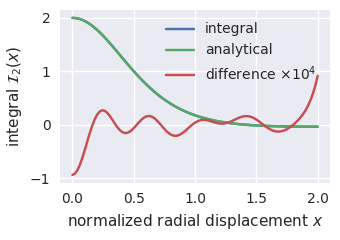

In [30]:
figs['01'] = plotbest(30,15.)
figs['01']

# Conclusion

For any choice of $N$ and $y_{\mathrm{max}}$, the error is smallest in ${\cal I}_0(x)$ and largest in ${\cal I}_2(x)$.  If we limit ourselves to a range of $0 \leq x \leq 2$, then the error in ${\cal I}_2(x)$ is minimized over this range by choosing $N \sim 30$ and $y_{\mathrm{max}} \sim 15$.


::: {.content-hidden when-format="html"}

# Save the figures

In [31]:
if 1:
    for num in figs.keys():
        figname = THIS + "Fig-" + num
        figs[num].savefig(figname + '.png', dpi=300)
        figs[num].savefig(figname + '.pdf')

# Formatting notes

The header at the top of this file is for creating a nicely-formatted `.html` document using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html`versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-55.ipynb && open dissipation-theory--Study-55.html
    
:::